In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import healpy as hp
from healpy.newvisufunc import projview
import fitsio
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u
import time
import os
import sys

import pymaster as nmt

#sys.path.insert(0, '/home/aew492/lss-dipoles')
#sys.path.insert(0, '/home/investigator/code/lss-dipoles')
sys.path.insert(0, '../code')
import plotter
import generate_mocks as gm
# import tools
# from qso_sample import QSOSample
# import dipole
# import ellisbaldwin
# import multipoles
# from jackknife import get_longitude_subsamples_from_hpmap, compute_jackknife_uncertainty, covar_jackknife

In [3]:
import matplotlib
matplotlib.rcParams['ytick.labelsize'] = 20
matplotlib.rcParams['xtick.labelsize'] = 20
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['legend.fontsize'] = 16
matplotlib.rcParams['axes.titlesize'] = 26

matplotlib.rc('text', usetex=True)

In [4]:
set_name = 'ideal_catwise'
tag_fig = f'_{set_name}'
catalog_name = 'catwise' #'quaia_G20.0'
selfunc_mode = 'catwise_zodi' #'quaia_G20.0_orig'
case_dict_data = {
    "catalog_name": catalog_name,
    "selfunc_mode": selfunc_mode, #this also multiplies in the mask
    "tag": f"_case-{selfunc_mode}"
}
case_dicts_mock = gm.case_set(set_name=set_name)

In [5]:
#plotter.plot_dipole_comps_vs_Lambdas(case_dict_data, case_dicts_mock[0])

In [6]:
n_amps = 20
n_excess = 10
case_dicts_grid = gm.grid_case_set('grid_catwise', n_amps, n_excess)

In [7]:
case_dicts_grid[0]

{'Cell_mode': 'excess',
 'dipole_amp': 0.0037,
 'excess': 1e-06,
 'selfunc_mode': 'catwise_zodi',
 'base_rate': 72.42,
 'tag': '_case-excess-1.00e-06-catwise_zodi-0.0037-72.420'}

In [8]:
import glob

def plot_dipole_comps_vs_Lambdas(#fn_comps_data, fns_comps_mocks, 
                                 case_dict_data, case_dict_mock,
                                 title='', fn_fig=None,
                                 dir_results_mocks=None):

    RESULTDIR = '/scratch/aew492/lss-dipoles_results'

    dir_results_data = os.path.join(RESULTDIR, 'results/results_data')
    if dir_results_mocks is None:
        dir_results_mocks = os.path.join(RESULTDIR, 'results/results_mocks')

    # Load data
    fn_comps_data = os.path.join(dir_results_data, f"dipole_comps_Lambdas_{case_dict_data['catalog_name']}{case_dict_data['tag']}.npy")
    result_dict = np.load(fn_comps_data, allow_pickle=True).item()
    dipole_comps_data = result_dict['dipole_comps']
    Lambdas_data = result_dict['Lambdas']

    # Load mock
    Lambdas_mocks = []
    dipole_amps_mocks = []
    pattern = f"{dir_results_mocks}/dipole_comps_lambdas*{case_dict_mock['tag']}*.npy"
    print(f"looking for {pattern}...")
    fn_comps_mock = glob.glob(pattern)
    n_trials = len(fn_comps_mock)
    print(f"found {n_trials} files with this pattern")

    # not necessary in order, careful!
    for i in range(n_trials):
        result_dict = np.load(fn_comps_mock[i],  allow_pickle=True).item()
        dipole_amps_mock = np.linalg.norm(result_dict['dipole_comps'], axis=-1)
        dipole_amps_mocks.append(dipole_amps_mock)
        Lambdas_mocks.append(result_dict['Lambdas'])
    dipole_amps_mocks = np.array(dipole_amps_mocks)

    # Compute the norm of the dipole components for the actual data
    dipole_amps_data = np.linalg.norm(dipole_comps_data, axis=1)

    # Plot data
    plt.figure(figsize=(10, 6))
    plt.plot(Lambdas_data, dipole_amps_data, lw=3, color='k', label='Data', zorder=100)

    # Plot each mock trial with light red lines
    for i in range(n_trials):        
        label = 'Mock' if i==0 else ''
        plt.plot(Lambdas_mocks[i], dipole_amps_mocks[i], color='lightcoral', linewidth=0.5,
                 label=label)

    # Plot the input dipole amplitude for the mocks
    plt.axhline(case_dict_mock['dipole_amp'], color='red', ls='--', alpha=0.8, label='Input dipole amp.')

    # Plot the mean of the mock data with a dark red line
    dipole_amps_mock_mean = np.mean(dipole_amps_mocks, axis=0)
    plt.plot(Lambdas_mocks[0], dipole_amps_mock_mean, color='red', linewidth=3, 
             label=f'Mean of {n_trials} mocks', zorder=10)
    # Also plot the 1sigma
    dipole_amps_mock_std = np.std(dipole_amps_mocks, axis=0)
    # plt.plot(Lambdas_mocks[0], dipole_amps_mock_mean - dipole_amps_mock_std,
    #                     color='red', alpha=0.5)
    # plt.plot(Lambdas_mocks[0], dipole_amps_mock_mean + dipole_amps_mock_std,
    #                     color='red', alpha=0.5)
    plt.fill_between(Lambdas_mocks[0], dipole_amps_mock_mean - dipole_amps_mock_std,
                        dipole_amps_mock_mean + dipole_amps_mock_std,
                        color='darkorange', alpha=0.4, label=r'1$\sigma$')

    # Adding grid, labels and legend
    plt.grid(alpha=0.5, lw=0.5)
    plt.xscale('log')

    plt.xlabel(r'$\Lambda$')
    plt.ylabel(r'$\mathcal{D}$, dipole amplitude')
    plt.title(title)
    plt.legend()

looking for /scratch/aew492/lss-dipoles_results/results/results_mocks/grid_catwise/dipole_comps_lambdas*_case-excess-1.00e-06-catwise_zodi-0.0037-72.420*.npy...
found 12 files with this pattern


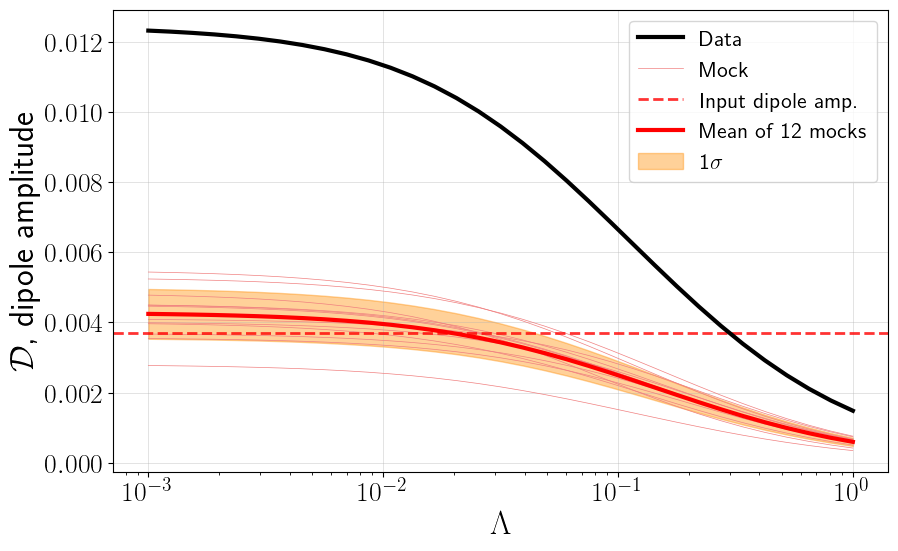

In [9]:
dir_results_mocks = '/scratch/aew492/lss-dipoles_results/results/results_mocks/grid_catwise'
plot_dipole_comps_vs_Lambdas(case_dict_data, case_dicts_grid[0], dir_results_mocks=dir_results_mocks)
#plotter.plot_dipole_comps_vs_Lambdas(case_dict_data, case_dicts_grid[0])

In [10]:
len(case_dicts_grid)

200

In [11]:
case_dicts_grid[0]

{'Cell_mode': 'excess',
 'dipole_amp': 0.0037,
 'excess': 1e-06,
 'selfunc_mode': 'catwise_zodi',
 'base_rate': 72.42,
 'tag': '_case-excess-1.00e-06-catwise_zodi-0.0037-72.420'}

In [12]:
dipole_amps = [case_dict['dipole_amp'] for case_dict in case_dicts_grid]
excesses = [case_dict['excess'] for case_dict in case_dicts_grid]

In [13]:
import glob

def get_dipole_comps_mock(case_dict_mock, dir_results_mocks=None):

    RESULTDIR = '/scratch/aew492/lss-dipoles_results'

    dir_results_data = os.path.join(RESULTDIR, 'results/results_data')
    if dir_results_mocks is None:
        dir_results_mocks = os.path.join(RESULTDIR, 'results/results_mocks')

    # Load mock
    Lambdas_mocks = []
    dipole_amps_mocks = []
    pattern = f"{dir_results_mocks}/dipole_comps_lambdas*{case_dict_mock['tag']}*.npy"
    print(f"looking for {pattern}...")
    fn_comps_mock = glob.glob(pattern)
    n_trials = len(fn_comps_mock)
    print(f"found {n_trials} files with this pattern")

    if n_trials==0:
        return np.nan
    
    # not necessary in order, careful!
    for i in range(n_trials):
        result_dict = np.load(fn_comps_mock[i],  allow_pickle=True).item()
        dipole_amps_mock = np.linalg.norm(result_dict['dipole_comps'], axis=-1)
        dipole_amps_mocks.append(dipole_amps_mock)
        Lambdas_mocks.append(result_dict['Lambdas'])
    dipole_amps_mocks = np.array(dipole_amps_mocks)

    dipole_amps_mock_mean = np.mean(dipole_amps_mocks, axis=0)
    # for now, grab the smallest lambda
    i_minlambda = np.argmin(result_dict['Lambdas'])
    dipole_amp_minlambda = dipole_amps_mock_mean[i_minlambda]
    
    #dipole_amps_mock_std = np.std(dipole_amps_mocks, axis=0)
    return dipole_amp_minlambda

In [14]:
def get_dipole_comps_data():
    RESULTDIR = '/scratch/aew492/lss-dipoles_results'

    dir_results_data = os.path.join(RESULTDIR, 'results/results_data')
    # Load data
    fn_comps_data = os.path.join(dir_results_data, f"dipole_comps_Lambdas_{case_dict_data['catalog_name']}{case_dict_data['tag']}.npy")
    result_dict = np.load(fn_comps_data, allow_pickle=True).item()
    dipole_comps_data = result_dict['dipole_comps']
    dipole_amps_data = np.linalg.norm(dipole_comps_data, axis=1)

    i_minlambda = np.argmin(result_dict['Lambdas'])
    dipole_amp_minlambda = dipole_amps_data[i_minlambda]
    
    #dipole_amps_mock_std = np.std(dipole_amps_mocks, axis=0)
    return dipole_amp_minlambda

In [15]:
recovered_dipole_amps = []
for case_dict in case_dicts_grid:
    dipole_amps_mock_mean = get_dipole_comps_mock(case_dict, dir_results_mocks=dir_results_mocks)
    recovered_dipole_amps.append(dipole_amps_mock_mean)
recovered_dipole_amps = np.array(recovered_dipole_amps)

looking for /scratch/aew492/lss-dipoles_results/results/results_mocks/grid_catwise/dipole_comps_lambdas*_case-excess-1.00e-06-catwise_zodi-0.0037-72.420*.npy...
found 12 files with this pattern
looking for /scratch/aew492/lss-dipoles_results/results/results_mocks/grid_catwise/dipole_comps_lambdas*_case-excess-1.67e-06-catwise_zodi-0.0037-72.420*.npy...
found 12 files with this pattern
looking for /scratch/aew492/lss-dipoles_results/results/results_mocks/grid_catwise/dipole_comps_lambdas*_case-excess-2.78e-06-catwise_zodi-0.0037-72.420*.npy...
found 12 files with this pattern
looking for /scratch/aew492/lss-dipoles_results/results/results_mocks/grid_catwise/dipole_comps_lambdas*_case-excess-4.64e-06-catwise_zodi-0.0037-72.420*.npy...
found 12 files with this pattern
looking for /scratch/aew492/lss-dipoles_results/results/results_mocks/grid_catwise/dipole_comps_lambdas*_case-excess-7.74e-06-catwise_zodi-0.0037-72.420*.npy...
found 12 files with this pattern
looking for /scratch/aew492/ls

In [16]:
recovered_dipole_amps.shape

(200,)

In [17]:
dipole_amp_data = get_dipole_comps_data()
dipole_amp_data

0.012321310897772301

In [26]:
norm = matplotlib.colors.TwoSlopeNorm(vmin=np.min(recovered_dipole_amps[~np.isnan(recovered_dipole_amps)]), 
                                      vcenter=dipole_amp_data, 
                                      vmax=np.max(recovered_dipole_amps[~np.isnan(recovered_dipole_amps)]))

Text(0, 0.5, 'input excess power')

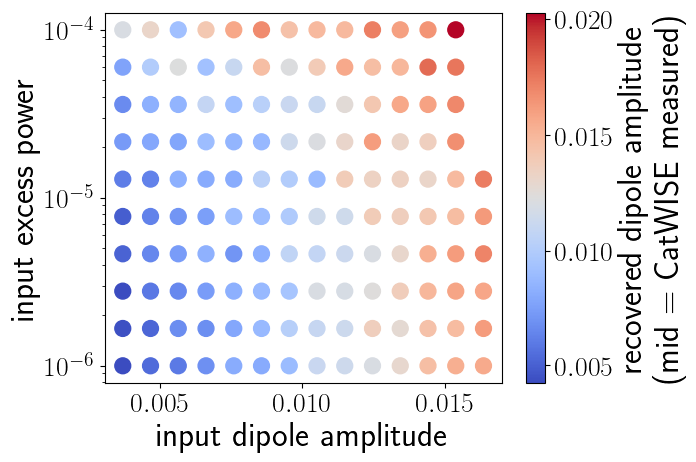

In [31]:
plt.scatter(dipole_amps, excesses, c=recovered_dipole_amps, cmap='coolwarm', norm=norm, s=130)
plt.yscale('log')
plt.colorbar(label='recovered dipole amplitude\n(mid = CatWISE measured)')
plt.xlabel('input dipole amplitude')
plt.ylabel('input excess power')

Text(0, 0.5, 'recovered dipole amplitude')

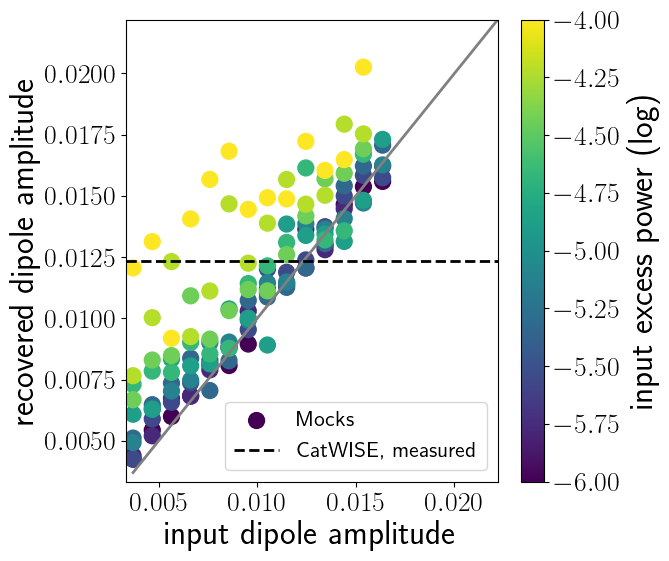

In [20]:
plt.figure(figsize=(6,6))
plt.scatter(dipole_amps, recovered_dipole_amps, c=np.log10(excesses), s=130, label='Mocks')
plt.plot(dipole_amps, dipole_amps, color='grey')

plt.axhline(dipole_amp_data, label='CatWISE, measured', color='black', ls='--')

plt.xlim(0.9*np.min(dipole_amps), np.max(dipole_amps))
plt.ylim(0.9*np.min(dipole_amps), np.max(dipole_amps))

plt.legend()
plt.colorbar(label='input excess power (log)')
plt.xlabel('input dipole amplitude')
plt.ylabel('recovered dipole amplitude')
